In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

# Dataset Overview

In [3]:
df = pd.read_csv("weatherAUS.csv")
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

<AxesSubplot:>

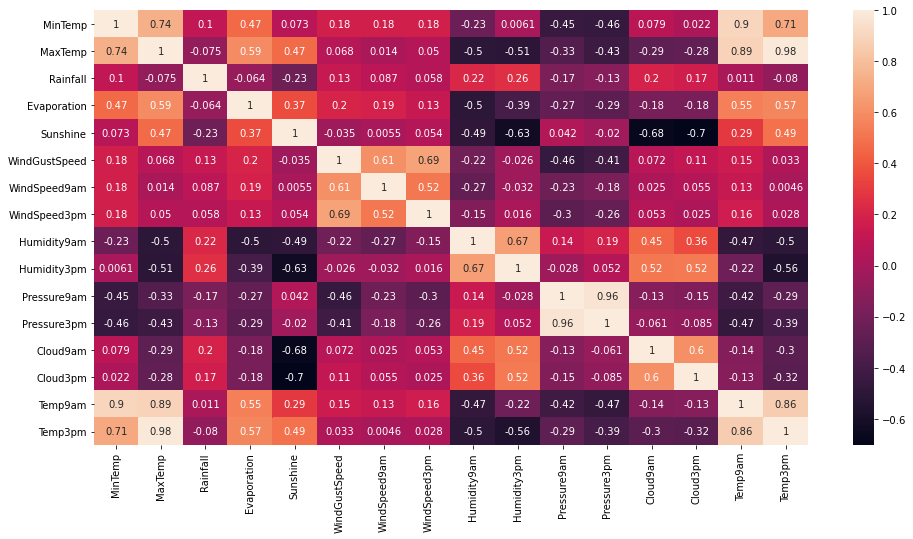

In [5]:
plt.figure(figsize=(16,8))
sns.heatmap(df.corr(), annot=True)

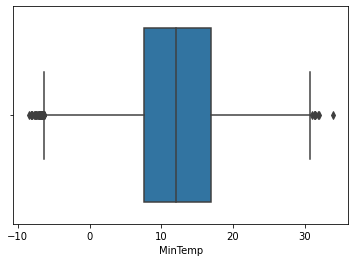

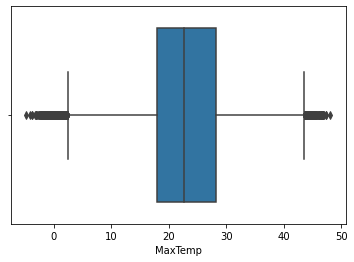

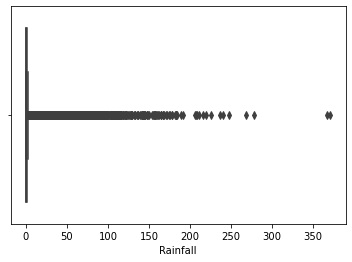

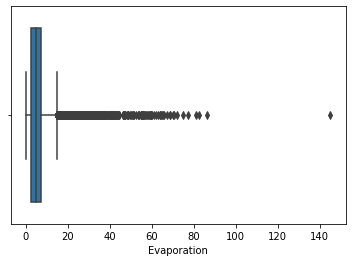

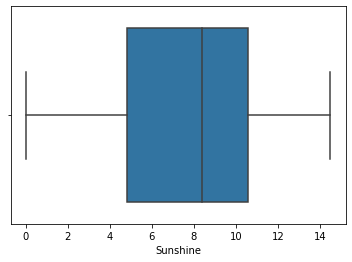

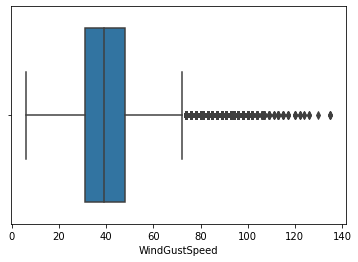

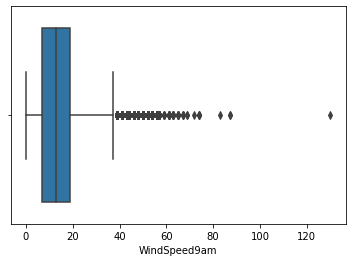

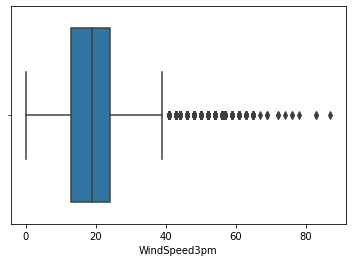

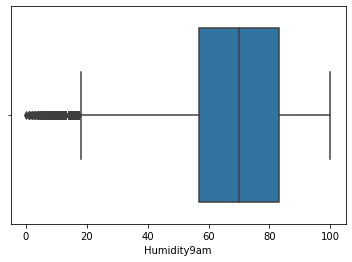

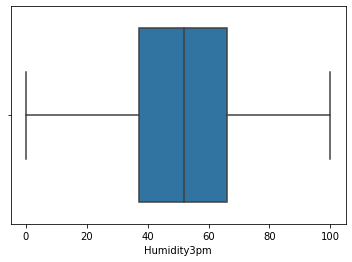

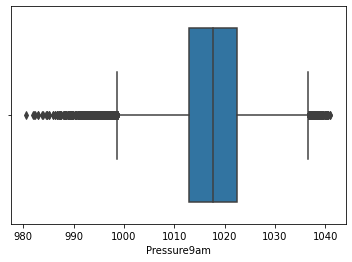

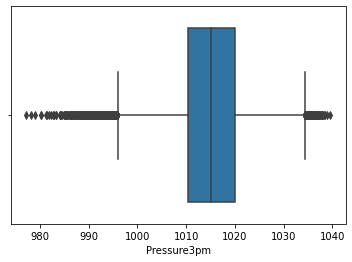

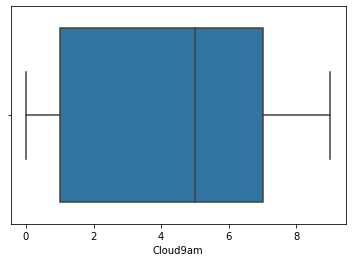

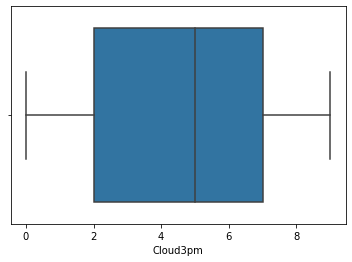

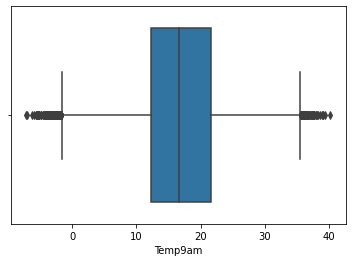

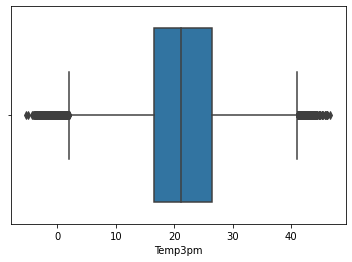

In [6]:
select_float = df.select_dtypes(include="float64").columns
for col in select_float:
    #df[col].hist(legend=True, bins=100)
    sns.boxplot(x=df[col])
    plt.show()

In [7]:
df.isna().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

# Feature Engineering

In [18]:
def feature_engi(df):
    #Drop unnecessary columns
    df.drop(["Location", "WindGustDir", "WindDir9am", "WindDir3pm"], inplace=True, axis=1)

    #Changing dtype from object to category
    select = df.select_dtypes(include="object").columns
    df[select] = df[select].astype("category")

    
    #Delete almost empty rows and duplicates
    df.drop_duplicates()
    df.dropna(thresh=10, inplace=True)


    #Handling time data
    #Creating Year and Month columns
    df["Date"] = pd.to_datetime(df["Date"])
    df["Year"] = df["Date"].dt.year
    df["Month"] = df["Date"].dt.month
    season_map = {
        12: "Winter",
        1: "Winter",
        2: "Winter",
        3: "Spring",
        4: "Spring",
        5: "Spring",
        6: "Summer",
        7: "Summer",
        8: "Summer",
        9: "Autumn",
        10: "Autumn",
        11: "Autumn"
    }
    #Creating Season column
    df["Season"] = df["Month"].map(season_map)
    del[df["Date"]]
    del[df["Month"]]
    #Drop rows with Year 2007 as there are too little observations
    df = df.loc[df["Year"] != 2007]


    #Deleting highly collinear columns
    df.drop(["Temp9am", "Temp3pm"], inplace=True, axis=1)


    #Deleting outliers
    select = ["WindSpeed9am", "WindSpeed3pm", "WindGustSpeed", "MaxTemp", "MinTemp"]
    for col in select:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        IQR = q3-q1
        mask = df[col].loc[(df[col] < (q1 - 1.5*IQR)) | (df[col] > (q3+1.5*IQR))]
        df.drop(labels=mask.index, inplace=True, errors=False)
    
    #Manually deleting certain outlier in columns
    index = df[df["Evaporation"] > 70].index
    df.drop(index, inplace=True)
    index = df[df["Rainfall"] > 150].index
    df.drop(index, inplace=True)
    del[df["Year"]]
    del[df["Season"]]


    #Fill missing values with mean data
    df.fillna(df.mean(), inplace=True)


    #Replace values with 1 or 0
    df.RainToday = df.RainToday.replace(["No", "Yes"], [0, 1])
    df["RainToday"].fillna(df["RainToday"].value_counts().index[0], inplace=True)
    df.RainTomorrow = df.RainTomorrow.replace(["No", "Yes"], [0, 1])
    df["RainTomorrow"].fillna(df["RainTomorrow"].value_counts().index[0], inplace=True)
    
    #Returning dataset
    return df

In [19]:
def split_data(df):
    features = df.loc[:, df.columns != "RainTomorrow"]
    target = df.RainTomorrow
    x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)
    
    #Scaling data
    cols_with_outliers = ["Rainfall", "Evaporation", "Sunshine"]
    cols = ["MinTemp", "MaxTemp", "WindGustSpeed", "WindSpeed9am", "WindSpeed3pm",\
            "Humidity9am", "Humidity3pm", "Pressure9am", "Pressure3pm", "Cloud9am", "Cloud3pm", "RainToday"]
    #Robust scaling for columns with outliers
    robust = RobustScaler()
    x_train[cols_with_outliers] = robust.fit_transform(x_train[cols_with_outliers])
    x_test[cols_with_outliers] = robust.transform(x_test[cols_with_outliers])
    
    #MinMax scaling
    min_max = MinMaxScaler()
    x_train[cols] = min_max.fit_transform(x_train[cols])
    x_test[cols] = min_max.transform(x_test[cols])
    
    return x_train, x_test, y_train, y_test

In [20]:
df = feature_engi(df)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\ProgramData\Anaconda3\lib

In [21]:
x_train, x_test, y_train, y_test = split_data(df)

<ipython-input-19-4663d75c1507>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train[cols_with_outliers] = robust.fit_transform(x_train[cols_with_outliers])
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs